In [1]:
from keras_retinanet.utils.image import read_image_bgr
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
os.getcwd()

'/Users/fschipani/Desktop/Tesi/MSc-Thesis-PJ/Playgrounds'

In [2]:
# load images
img_vis = read_image_bgr(Path(os.getcwd()+'/TestFile/I02434_visible.jpg')) 
img_lwir = read_image_bgr(Path(os.getcwd()+'/TestFile/I02434_lwir.jpg')) 
img_lwir.shape

(512, 640, 3)

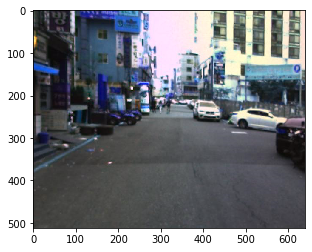

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img_vis)
plt.show()

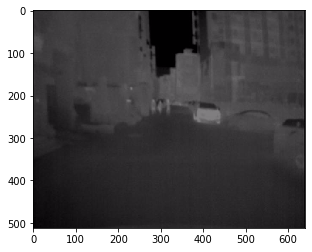

In [4]:
plt.imshow(img_lwir)
plt.show()

In [5]:
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

Using TensorFlow backend.


In [6]:
# load annotations with standard csv generator of keras_retinanet
transform_generator = None
visual_effect_generator = None
# maybe later: auto_augment = something
image_min_side = 800 #std value
image_max_side = 1333 #std value
pth = Path(os.getcwd())
generator = CSVGenerator(
            pth.joinpath('TestFile/l02434_bb.csv'),
            pth.joinpath('TestFile/class_id.csv'),
            transform_generator=transform_generator,
            visual_effect_generator=visual_effect_generator,
            image_min_side=image_min_side,
            image_max_side=image_max_side,
            config=None
        )
annotations = generator.load_annotations(0)
# 0: person
# 1: cars
print(str(annotations)) 


{'labels': array([0., 0., 0., 1., 1.]), 'bboxes': array([[305., 220., 329., 263.],
       [290., 221., 309., 261.],
       [275., 217., 295., 264.],
       [378., 208., 444., 263.],
       [462., 224., 599., 287.]])}


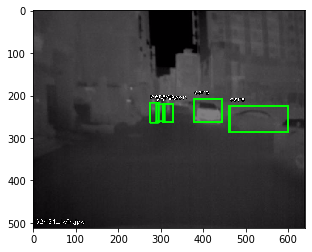

In [7]:
from keras_retinanet.utils.visualization import draw_annotations, draw_boxes, draw_caption
from keras_retinanet.utils.anchors import anchors_for_shape, compute_gt_annotations

#reload image for test purpose
img_lwir = read_image_bgr(Path(os.getcwd()+'/TestFile/I02434_lwir.jpg'))
img_lwir_annotated = img_lwir
anchors = anchors_for_shape(img_lwir_annotated.shape, anchor_params=None)
positive_indices, _, max_indices = compute_gt_annotations(anchors, annotations['bboxes'])

draw_annotations(img_lwir_annotated, annotations, color=(0, 0, 255), label_to_name=generator.label_to_name)
draw_boxes(img_lwir_annotated, annotations['bboxes'][max_indices[positive_indices], :], (0, 255, 0))
draw_caption(img_lwir_annotated, [0, img_lwir_annotated.shape[0]], os.path.basename(generator.image_path(0)))

plt.imshow(img_lwir_annotated)
plt.show()

In [8]:
#reload image for test purpose
img_lwir = read_image_bgr(Path(os.getcwd()+'/TestFile/I02434_lwir.jpg'))
#normalize to [0,1]
normalized_annotations = np.zeros(annotations['bboxes'].shape)

normalized_annotations[:,0] = annotations['bboxes'][:,0] / 640
normalized_annotations[:,2] = annotations['bboxes'][:,2] / 640
normalized_annotations[:,1] = annotations['bboxes'][:,1] / 512
normalized_annotations[:,3] = annotations['bboxes'][:,3] / 512

############################
normalized_annotations[:, [0,1]] = normalized_annotations[:,[1,0]]
normalized_annotations[:, [3,2]] = normalized_annotations[:,[2,3]]
############################

normalized_annotations = tf.compat.v2.convert_to_tensor(normalized_annotations, dtype=tf.float32)
normalized_annotations

<tf.Tensor: id=0, shape=(5, 4), dtype=float32, numpy=
array([[0.4296875 , 0.4765625 , 0.5136719 , 0.5140625 ],
       [0.43164062, 0.453125  , 0.5097656 , 0.4828125 ],
       [0.42382812, 0.4296875 , 0.515625  , 0.4609375 ],
       [0.40625   , 0.590625  , 0.5136719 , 0.69375   ],
       [0.4375    , 0.721875  , 0.5605469 , 0.9359375 ]], dtype=float32)>

In [9]:
from keras_retinanet.utils.autoaugment_utils_tf2 import distort_image_with_autoaugment
augmented_img, augmented_annotation = distort_image_with_autoaugment(
    tf.compat.v2.convert_to_tensor(img_lwir, dtype=tf.float32), 
    normalized_annotations, 
    'test')
augmented_annotation = augmented_annotation.numpy()
augmented_annotation[:, [0,1]] = augmented_annotation[:,[1,0]]
augmented_annotation[:, [3,2]] = augmented_annotation[:,[2,3]]
#revert to original size
augmented_annotation[:, 0] = augmented_annotation[:, 0] * 640
augmented_annotation[:, 2] = augmented_annotation[:, 2] * 640
augmented_annotation[:, 1] = augmented_annotation[:, 1] * 512
augmented_annotation[:, 3] = augmented_annotation[:, 3] * 512
augmented_annotation = augmented_annotation.astype(int)

tf.Tensor(
[[ 36. -15.]
 [ 36.   9.]
 [ -7. -15.]
 [ -7.   9.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[ 35. -30.]
 [ 35. -11.]
 [ -5. -30.]
 [ -5. -11.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[ 39. -45.]
 [ 39. -25.]
 [ -8. -45.]
 [ -8. -25.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[ 48.  57.]
 [ 48. 124.]
 [ -7.  57.]
 [ -7. 124.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[ 32. 142.]
 [ 32. 279.]
 [-31. 142.]
 [-31. 279.]], shape=(4, 2), dtype=float32)


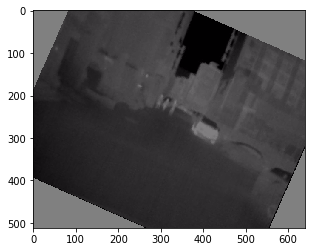

In [10]:
augmented_img = augmented_img.numpy().astype(np.uint8)
plt.imshow((augmented_img))

In [11]:
new_annotations = {
    'labels': annotations['labels'],
    'bboxes': augmented_annotation
}
annotated_img = augmented_img
anchors = anchors_for_shape(annotated_img.shape, anchor_params=None)
positive_indices, _, max_indices = compute_gt_annotations(anchors, new_annotations['bboxes'])
draw_annotations(annotated_img, new_annotations, color=(0, 0, 255), label_to_name=generator.label_to_name)
draw_boxes(annotated_img, augmented_annotation[max_indices[positive_indices], :], (0, 255, 0))
draw_caption(annotated_img, [0, annotated_img.shape[0]], os.path.basename(generator.image_path(0)))


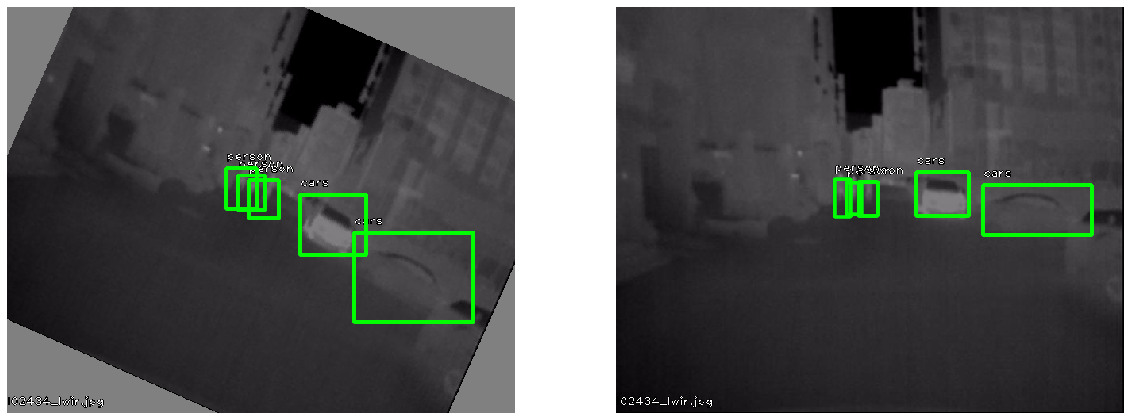

In [12]:
f = plt.figure(figsize=(20,10))
f.add_subplot(1,2, 1)
plt.axis('off')
plt.imshow(annotated_img)
f.add_subplot(1,2, 2)
plt.axis('off')
plt.imshow(img_lwir_annotated)
plt.show(block=True)

In [13]:
annotations['bboxes']


array([[305., 220., 329., 263.],
       [290., 221., 309., 261.],
       [275., 217., 295., 264.],
       [378., 208., 444., 263.],
       [462., 224., 599., 287.]])

In [14]:
new_annotations['bboxes']

array([[304, 218, 342, 266],
       [291, 212, 324, 256],
       [276, 203, 314, 254],
       [369, 236, 452, 312],
       [437, 284, 587, 397]])